Домашнее задание по теме «Кластеризация k-means»

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go # Создаем фигуру с заданными размерами
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# импортируем нужный класс для кластеризации k-means
from sklearn.cluster import KMeans

# Импорт функций silhouette_samples и silhouette_score
# из модуля sklearn.metrics для расчета коэффициента силуэта для каждого
# образца и общего коэффициента силуэта для всего набора данных.
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score

# Импортируем функции dump и load из модуля joblib.
# Эти функции позволяют сохранять и загружать объекты Python, включая модели машинного обучения,
# для последующего использования без необходимости повторного обучения модели.
from joblib import dump

Загружаем данные

In [90]:
train_df=pd.read_csv('penguins.csv')

In [91]:
pd.options.display.float_format = '{:,.2f}'.format
train_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.70,181.00,"3,750.00",MALE
1,39.50,17.40,186.00,"3,800.00",FEMALE
2,40.30,18.00,195.00,"3,250.00",FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.70,19.30,193.00,"3,450.00",FEMALE


In [42]:
train_df.info(memory_usage=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


Можно заметить, что в таблице есть пропуски. Оставим их для EDA, а для обучения модели заполним их.

In [43]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.58
culmen_depth_mm,0.58
flipper_length_mm,0.58
body_mass_g,0.58
sex,2.62


Выделяем категориальные и числовые столбцы и создаем подтаблицы для EDA.

In [92]:
category_col = train_df.select_dtypes(include=['object']).columns.tolist()
category_col

['sex']

In [93]:
train_df_cat = train_df[category_col]
number_col = train_df.select_dtypes(include=['number']).columns.tolist()
train_df_num = train_df[number_col]

Заполнение пропусков

In [94]:
train_df = train_df.apply(lambda x: x.fillna(x.mode()[0]))

In [95]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.00
culmen_depth_mm,0.00
flipper_length_mm,0.00
body_mass_g,0.00
sex,0.00


Для кодирования категориальных переменных будем использовать TargetOrdinalEncoding

# EDA

Для числовых столбцов:

In [64]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_num.isnull().sum() * 100 / len(train_df_num.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.58
culmen_depth_mm,0.58
flipper_length_mm,0.58
body_mass_g,0.58


In [65]:
#Находим максимальные и минимальные значения
min_max_df = pd.DataFrame({'Максимальное значение': train_df_num.max(), 'Минимальное значение': train_df_num.min()})

min_max_df

,Максимальное значение,Минимальное значение
culmen_length_mm,59.60,32.10
culmen_depth_mm,21.50,13.10
flipper_length_mm,"5,000.00",-132.00
body_mass_g,"6,300.00","2,700.00"


In [66]:
#Находим средние значения
mean_df = pd.DataFrame({'Среднее значение': train_df_num.mean()})

mean_df

,Среднее значение
culmen_length_mm,43.92
culmen_depth_mm,17.15
flipper_length_mm,214.01
body_mass_g,"4,201.75"


In [67]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df_num.median()})

median_df

,Медиана
culmen_length_mm,44.45
culmen_depth_mm,17.30
flipper_length_mm,197.00
body_mass_g,"4,050.00"


In [68]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df_num.var()})

var_df

,Диспрерсия
culmen_length_mm,29.81
culmen_depth_mm,3.90
flipper_length_mm,"67,890.50"
body_mass_g,"643,131.08"


In [69]:
#Находим квантиль 0.1 и 0.9
quantile_df = pd.DataFrame({'Квантиль 0.1': train_df_num.quantile(0.1), 'Квантиль 0.9': train_df_num.quantile(0.9)})

quantile_df

,Квантиль 0.1,Квантиль 0.9
culmen_length_mm,36.60,50.80
culmen_depth_mm,14.30,19.50
flipper_length_mm,185.00,221.00
body_mass_g,"3,300.00","5,400.00"


In [70]:
#Находим квартиль 1 и 3
quartile_df = pd.DataFrame({'Квартиль 1': train_df_num.quantile(0.25), 'Квартиль 3': train_df_num.quantile(0.75)})

quartile_df

,Квартиль 1,Квартиль 3
culmen_length_mm,39.23,48.50
culmen_depth_mm,15.60,18.70
flipper_length_mm,190.00,213.75
body_mass_g,"3,550.00","4,750.00"


Для категориальных столбцов:

In [71]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_cat.isnull().sum() * 100 / len(train_df_cat.index)
missing_category_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_category_value_df

,Незаполнено столбце %
sex,2.62


In [72]:
#Находим кол-во уникальных значений
unique_df = pd.DataFrame({'Уникальных значений в столбце': train_df_cat.nunique()})
unique_df

,Уникальных значений в столбце
sex,3


Нужно проверить какие значения в столбце sex.

In [73]:
#Находим моду столбцов
mode_df =  pd.DataFrame({'Мода в столбце':train_df_cat.mode().loc[0]})
mode_df

,Мода в столбце
sex,MALE


# Обработка данных

In [48]:
train_df_cat.value_counts()

sex   
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

Удаляем строчку с точкой 

In [96]:
train_df = train_df[train_df['sex'] != '.']
train_df['sex'].value_counts()

sex
MALE      178
FEMALE    165
Name: count, dtype: int64

Посмотрим распределение данных в столбцах

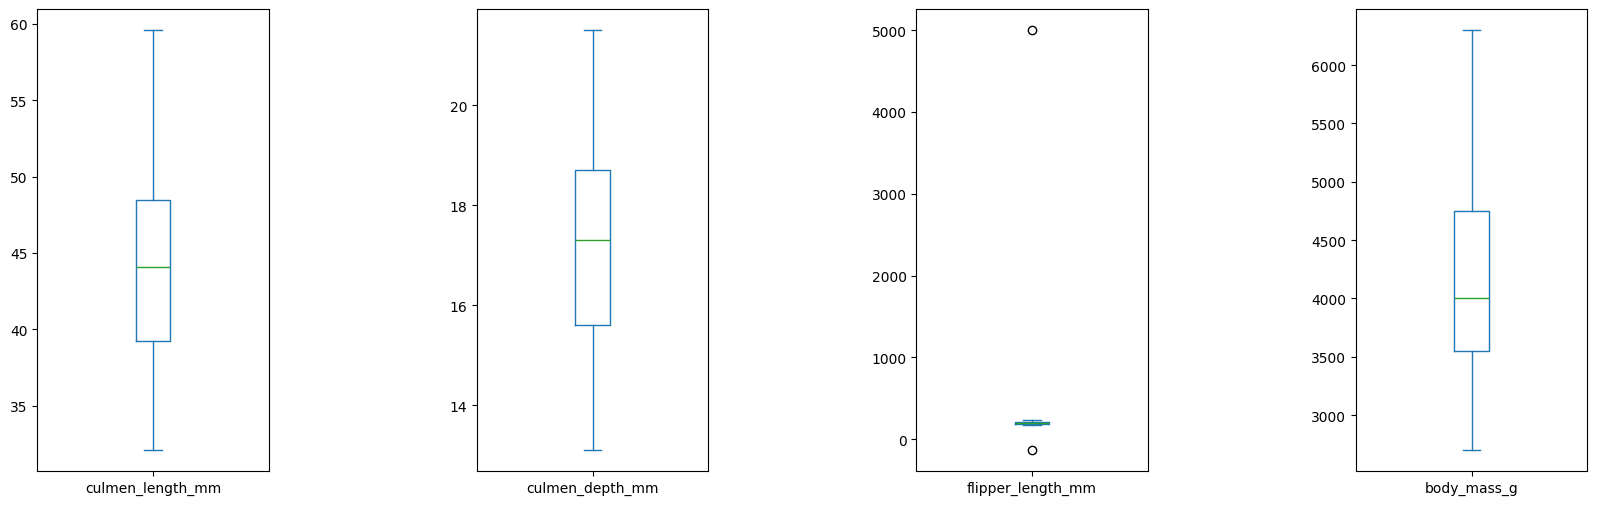

In [9]:
train_df.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

В столбце flipper_length_mm можно заметить выбросы. Избавимся от них

In [97]:
def RemoveOutliers(df, column):
    # убираем выбросы
    Q3 = np.quantile(df[column], 0.75, axis=0)
    Q1 = np.quantile(df[column], 0.25, axis=0)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df[column] = np.where((df[column] > upper), upper, df[column])
    df[column] = np.where((df[column] < lower), lower, df[column])
    return df

In [98]:
train_df = RemoveOutliers(train_df, 'flipper_length_mm')

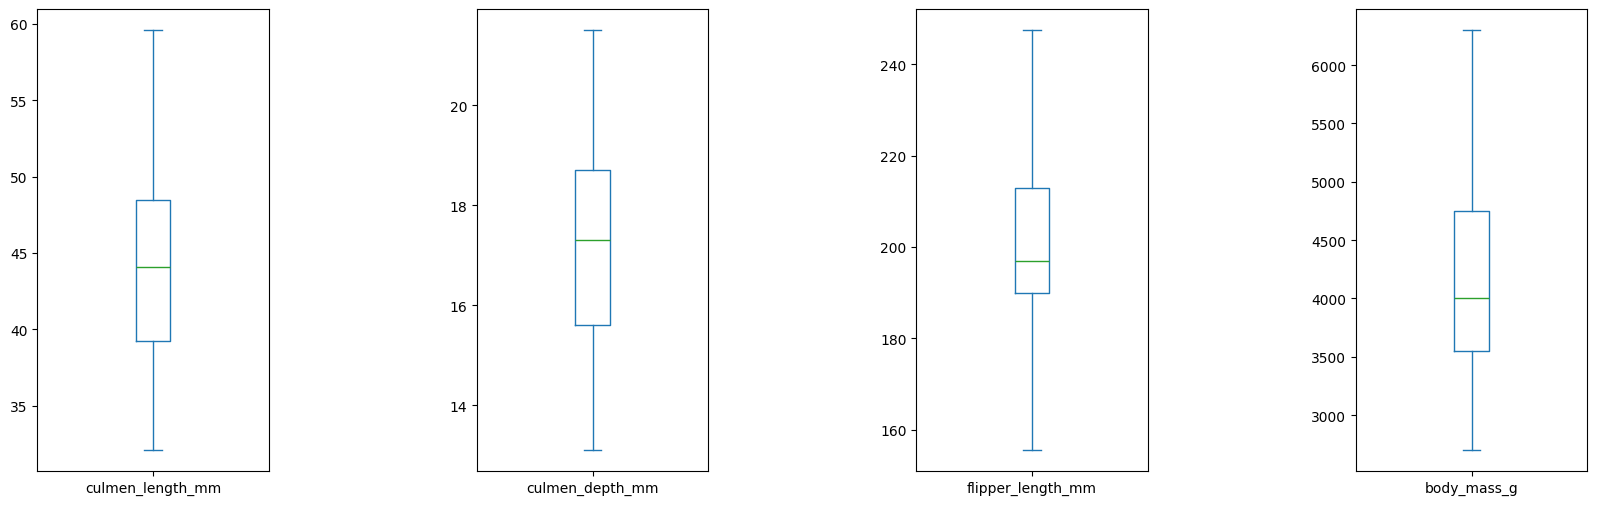

In [99]:
train_df.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

Посмотрим парную корреляцию столбцов.

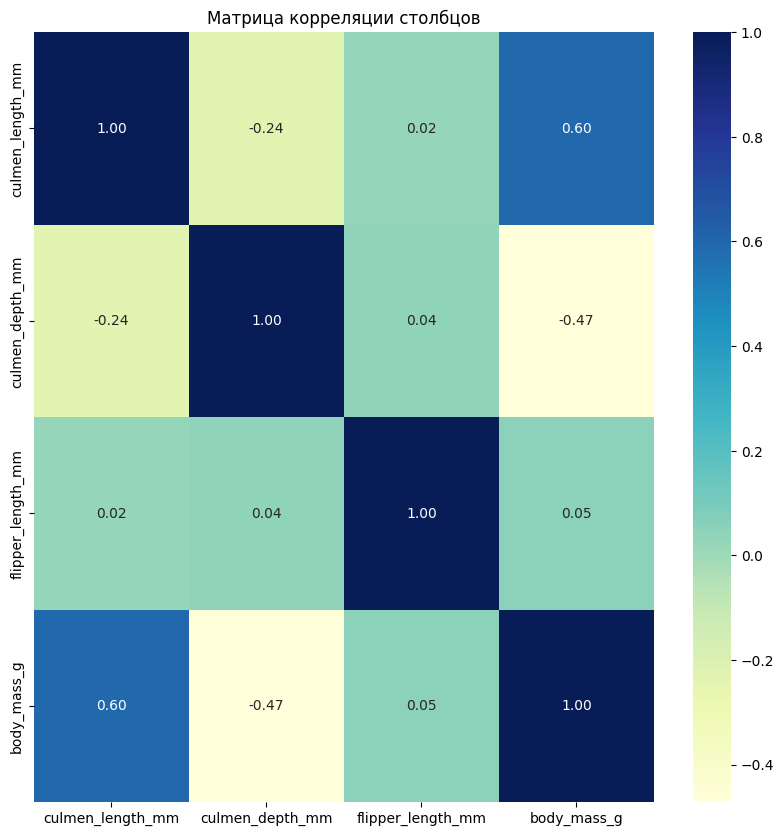

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(train_df_num.corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Матрица корреляции столбцов")
plt.show()

Нет необходимости какой-либо из столбцов удалять.

# Подготовка датасета

Закодируем категориальные переменные

In [100]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
sex = encoder.fit_transform(train_df['sex'])
encoded_df = train_df.drop("sex", axis=1)
encoded_df['sex'] = sex
encoded_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.70,181.00,"3,750.00",1
1,39.50,17.40,186.00,"3,800.00",0
2,40.30,18.00,195.00,"3,250.00",0
3,41.10,17.00,190.00,"3,800.00",1
4,36.70,19.30,193.00,"3,450.00",0
...,...,...,...,...,...
339,41.10,17.00,190.00,"3,800.00",1
340,46.80,14.30,215.00,"4,850.00",0
341,50.40,15.70,222.00,"5,750.00",1
342,45.20,14.80,212.00,"5,200.00",0


Нормализируем данные

In [101]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
df_scaled = pd.DataFrame(Scaler.fit_transform(encoded_df), columns=encoded_df.columns)
df_scaled

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.88,0.79,-1.37,-0.56,0.96
1,-0.81,0.12,-1.03,-0.50,-1.04
2,-0.66,0.43,-0.41,-1.19,-1.04
3,-0.51,-0.08,-0.75,-0.50,0.96
4,-1.32,1.09,-0.54,-0.94,-1.04
...,...,...,...,...,...
338,-0.51,-0.08,-0.75,-0.50,0.96
339,0.53,-1.45,0.98,0.82,-1.04
340,1.19,-0.74,1.46,1.94,0.96
341,0.24,-1.20,0.77,1.25,-1.04


In [78]:
df_scaled.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   343 non-null    float64
 1   culmen_depth_mm    343 non-null    float64
 2   flipper_length_mm  343 non-null    float64
 3   body_mass_g        343 non-null    float64
 4   sex                343 non-null    float64
dtypes: float64(5)
memory usage: 13.5 KB


Уменьшим размерность датафрейма.

In [102]:
int_cols = df_scaled.select_dtypes('int').columns

float_cols = df_scaled.select_dtypes('float').columns
for col in int_cols:
    df_scaled[col] = pd.to_numeric(df_scaled[col], downcast='integer')
for col in float_cols:
    df_scaled[col] = pd.to_numeric(df_scaled[col], downcast='float')

In [80]:
df_scaled.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   343 non-null    float32
 1   culmen_depth_mm    343 non-null    float32
 2   flipper_length_mm  343 non-null    float32
 3   body_mass_g        343 non-null    float32
 4   sex                343 non-null    float32
dtypes: float32(5)
memory usage: 6.8 KB


# Примените метод кластеризации KMeans с подбором гиперпараметров в цикле

In [103]:
RAND_STATE = 42

In [104]:
# создадим пустой список для записи показателя WCSS (ошибки, cуммы квадратов внутрикластерных расстояний)
wcss = []

# воспользуемся функцией range(), она возвращает последовательность чисел
# в данном случае числа от 1 до 10
min_range = 1
max_range = 11 # до максимального, не включая

for i in range(min_range, max_range):
    # настроим параметры модели
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = RAND_STATE, init="k-means++", algorithm="lloyd")

    # обучим модель на наших данных с разным количеством кластеров
    kmeans.fit(df_scaled)

    # для каждого кластера рассчитаем ошибку (атрибут inertia_) и поместим в список
    wcss.append(kmeans.inertia_)

# Оцените качество кластеризации методом локтя. Сделайте вывод

In [105]:
# Создаем фигуру с заданными размерами
fig = go.Figure()

# Добавляем линейный график с данными о WCSS по количеству кластеров
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=wcss, mode='lines', name='WCSS'))

# Настройка заголовков и осей
fig.update_layout(
    title='Выбор количества кластеров методом локтя',
    xaxis_title='Количество кластеров',
    yaxis_title='WCSS'
)

# Отображаем график
fig.show()

За локоть графика можно считать точку 4. Это и будет оптимальным кол-вом кластеров.

# Оцените качество кластеризации методом силуэта. Сделайте вывод

In [106]:
# Уменьшение размерности входных данных с помощью PCA
reduced_data = PCA(n_components=2, random_state=RAND_STATE).fit_transform(df_scaled)

For n_clusters = 2 The average silhouette_score is : 0.52610266
For n_clusters = 3 The average silhouette_score is : 0.5572435
For n_clusters = 4 The average silhouette_score is : 0.63457173
For n_clusters = 5 The average silhouette_score is : 0.5855854
For n_clusters = 6 The average silhouette_score is : 0.5742475
For n_clusters = 7 The average silhouette_score is : 0.55150795
For n_clusters = 8 The average silhouette_score is : 0.5129383
For n_clusters = 9 The average silhouette_score is : 0.506467
For n_clusters = 10 The average silhouette_score is : 0.45527706


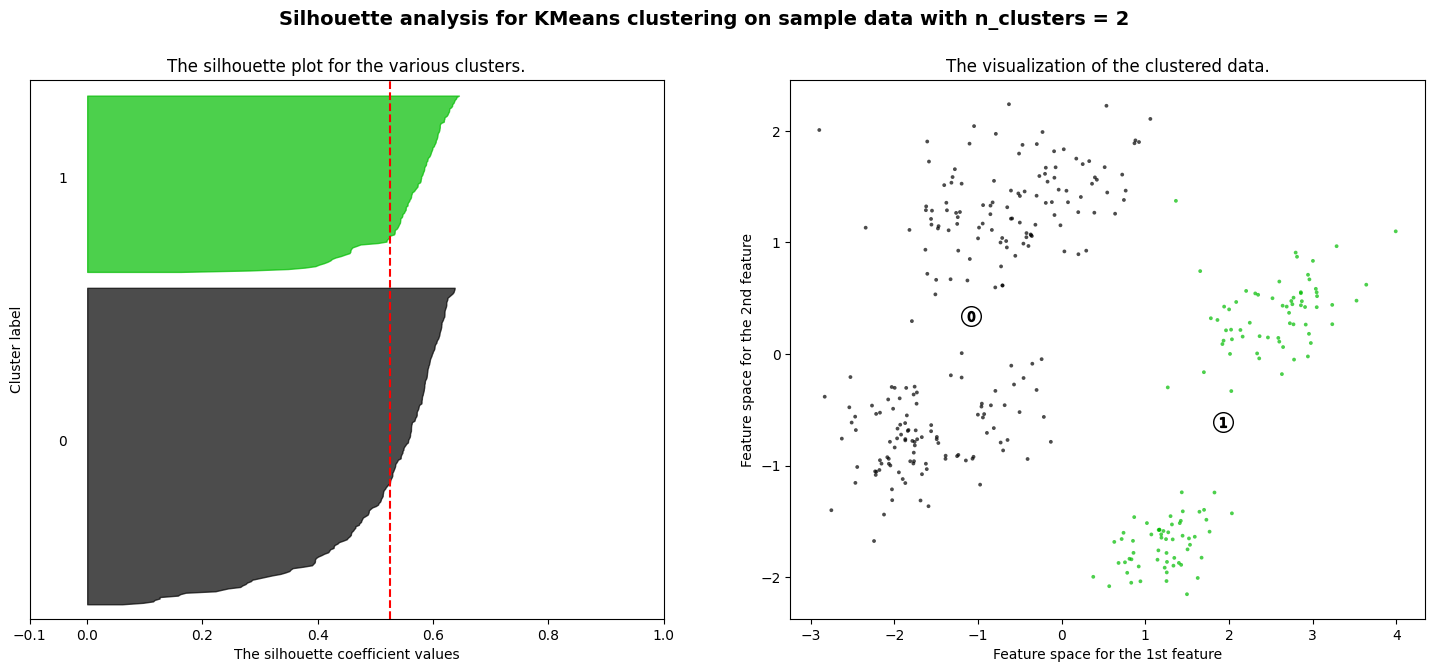

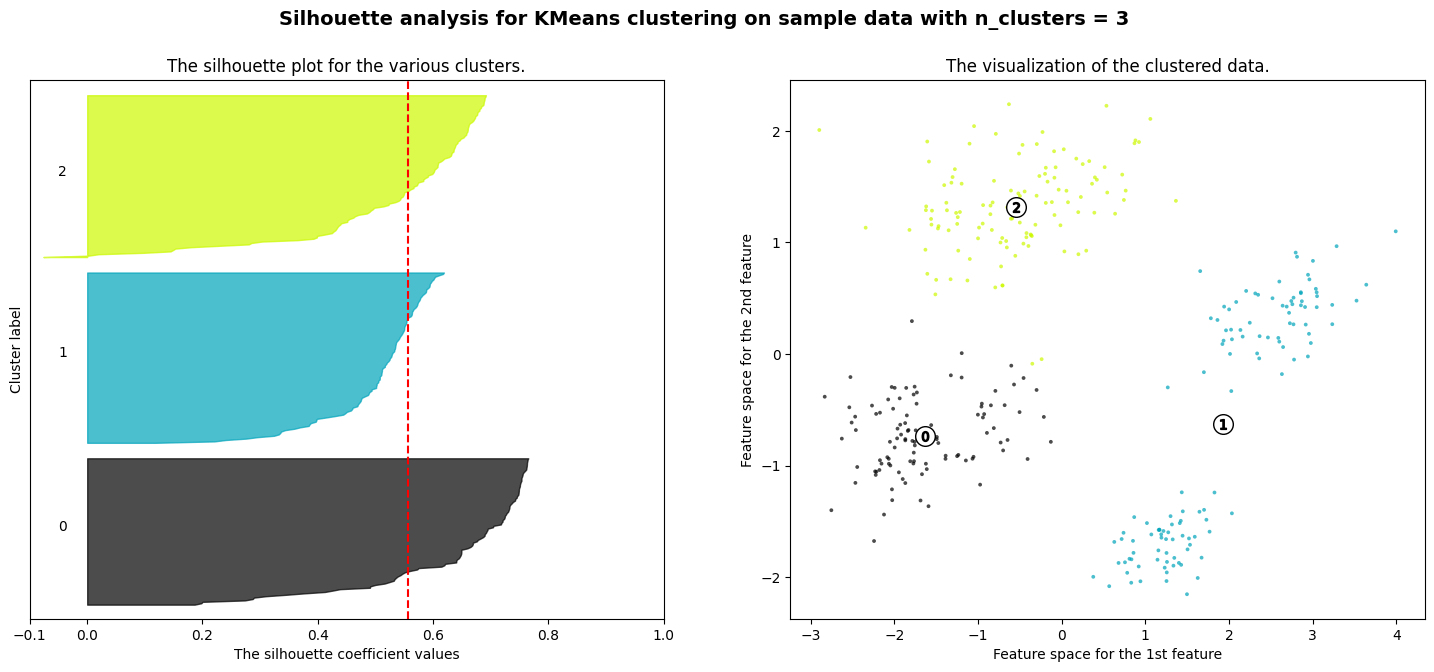

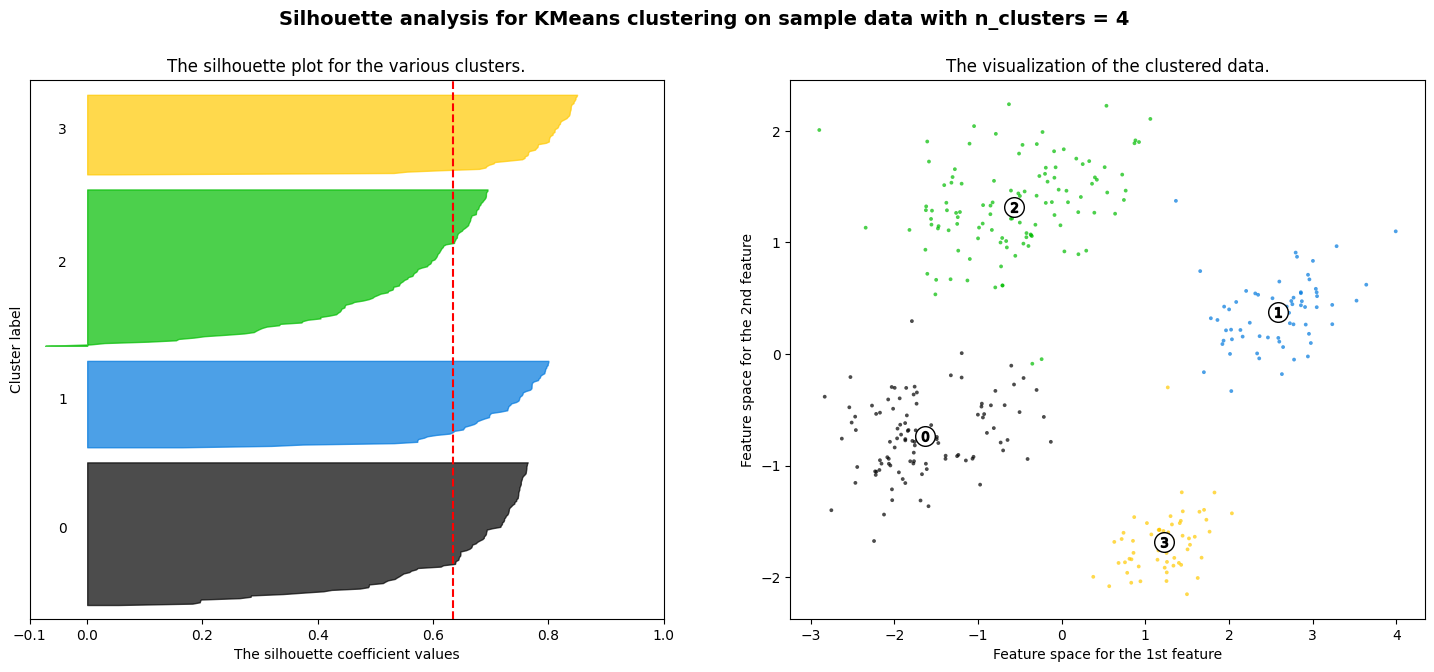

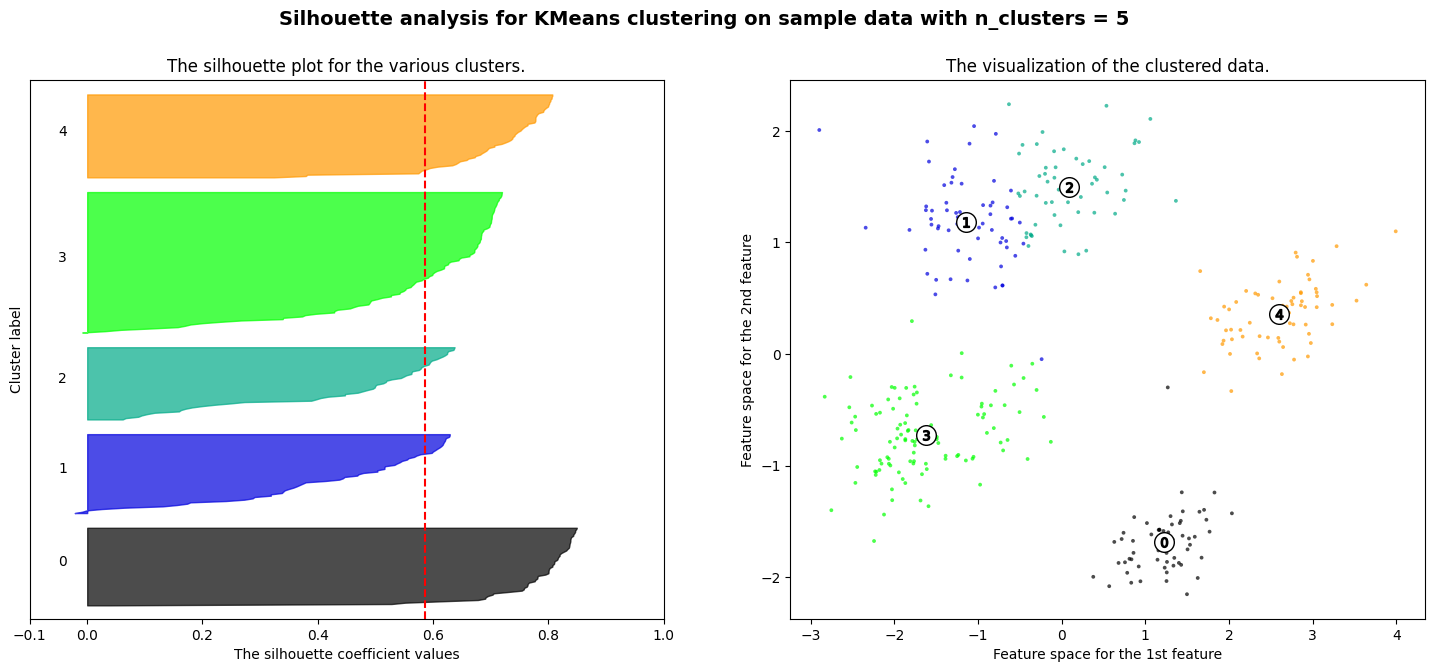

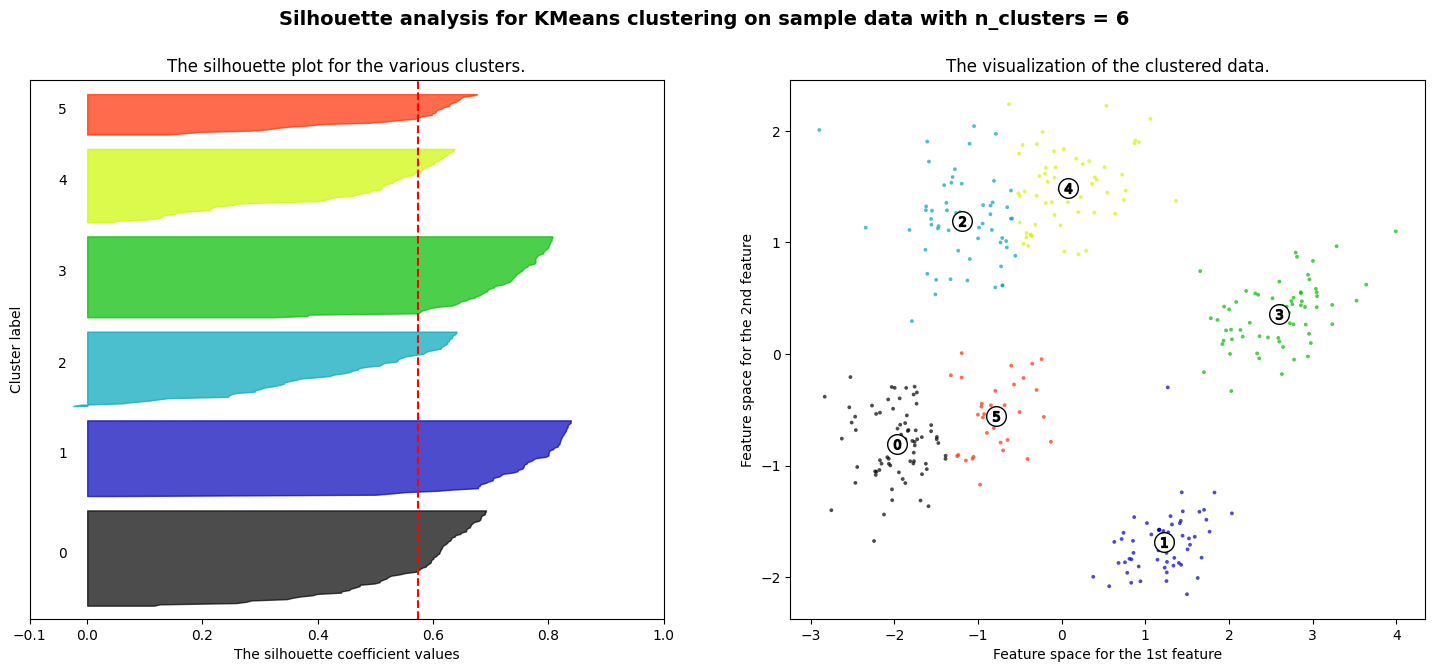

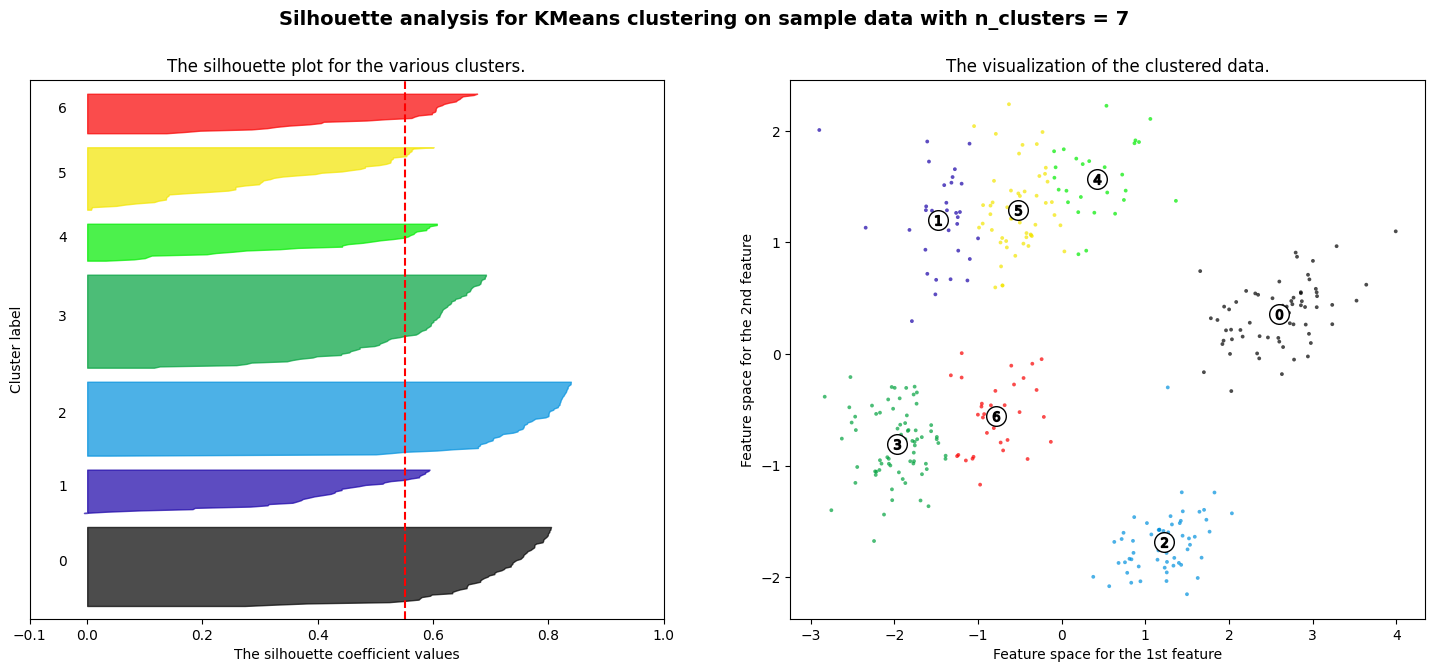

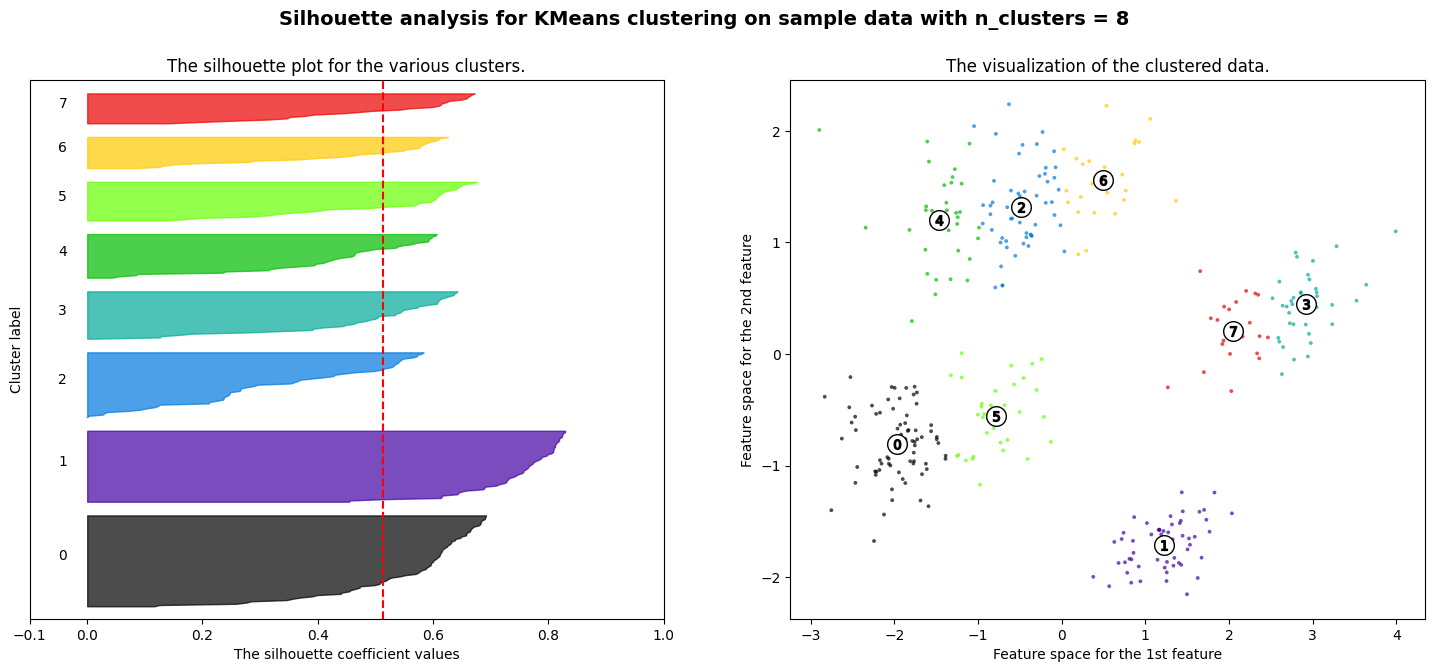

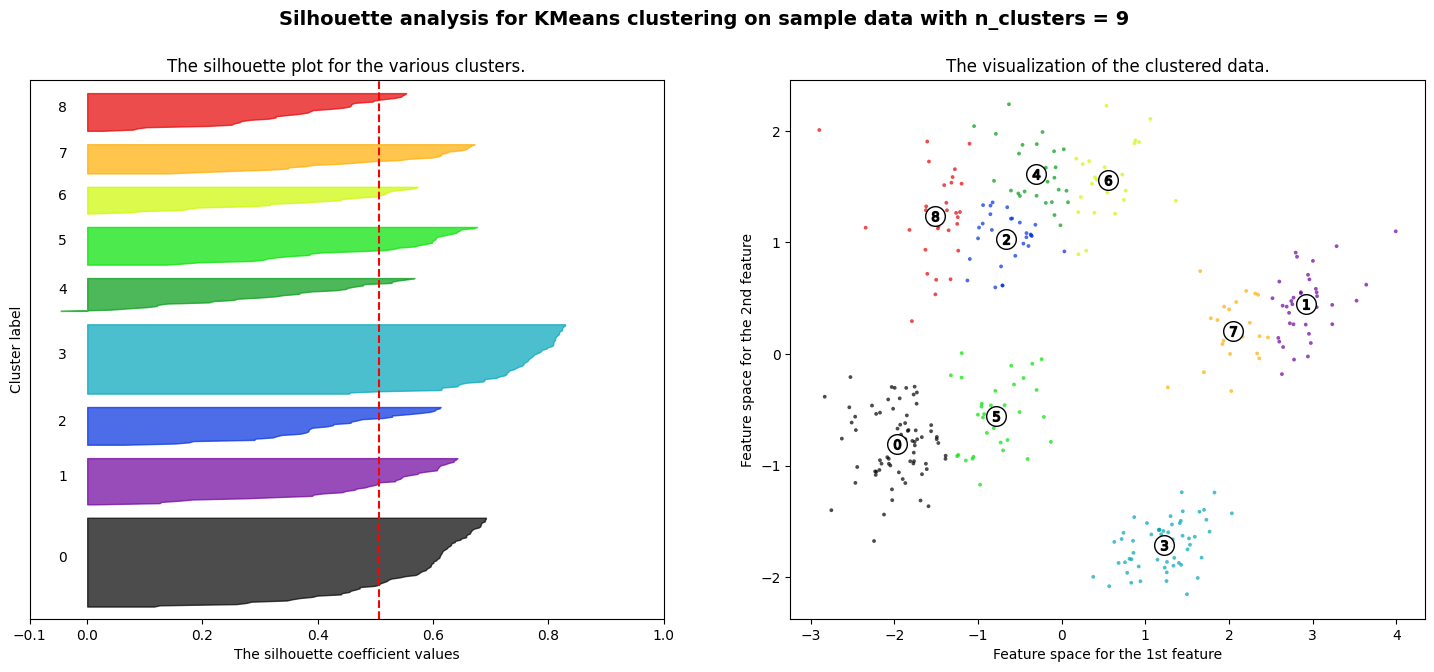

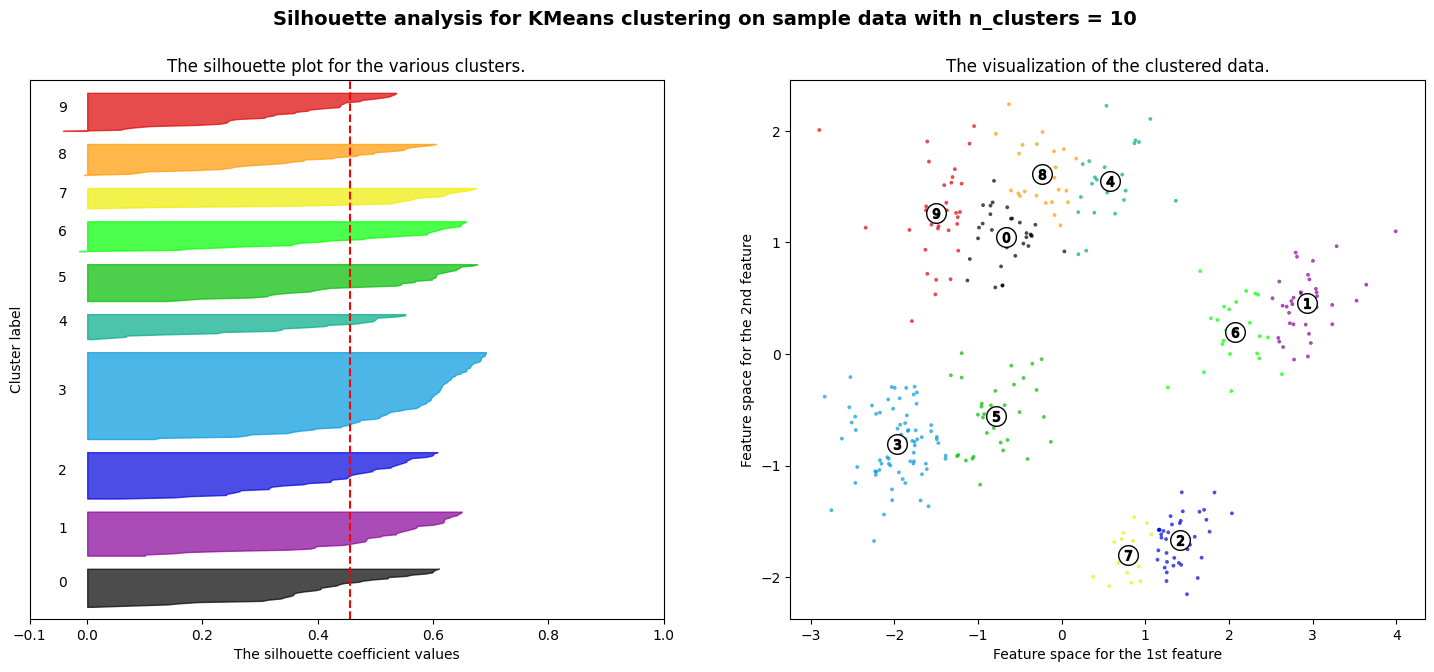

In [86]:
# Создадим пустой список для записи коэффициентов силуэта для каждого образца
sample_silhouette_values = []

# Воспользуемся функцией range(), она возвращает последовательность чисел
# в данном случае числа от 1 до 10
min_range = 2
max_range = 11  # до максимального, не включая

for i in range(min_range, max_range):
    # Создайте подзаголовок с 1 строкой и 2 столбцами
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Первый подсюжет — это график силуэта
    # Коэффициент силуэта может варьироваться от -1 до 1, но в этом примере все
    # лежат в пределах [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # (n_clusters+1)*10 предназначен для вставки пустого пространства между силуэтами
    # графики отдельных кластеров, чтобы четко их разграничить.
    ax1.set_ylim([0, len(reduced_data) + (i + 1) * 10])

    # Инициализируем кластеризатор значением n_clusters и генератором случайных чисел
    # начальное число из 10 для воспроизводимости.
    clusterer = KMeans(n_clusters=i, max_iter = 300, n_init = 10, random_state = RAND_STATE, init="k-means++")
    cluster_labels = clusterer.fit_predict(reduced_data)

    # Silhouette_score дает среднее значение для всех образцов.
    # Это дает представление о плотности и разделении образовавшихся
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print(
        "For n_clusters =", i, "The average silhouette_score is :", silhouette_avg,
    ) # рассчет коэффициента, можно без визуализации

    # Вычисляем оценки силуэта для каждого образца
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for j in range(i):
        # Объединить оценки силуэтов для образцов, принадлежащих
        # кластер j и отсортируйте их
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / i)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Пометьте графики силуэтов номерами их кластеров посередине.
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Вычисляем новый y_lower для следующего графика
        y_lower = y_upper + 10  # 10 для 0 образцов

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Вертикальная линия для средней оценки силуэта всех значений.
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Очистите метки/галочки Yaxis
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2-й график, показывающий фактически сформированные кластеры
    colors = cm.nipy_spectral(cluster_labels.astype(float) / i)
    ax2.scatter(
        reduced_data[:, 0], reduced_data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Маркировка кластеров
    centers = clusterer.cluster_centers_
    # Нарисуйте белые круги в центрах кластеров
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for k, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % k, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


У модели с 4 кластерами силует ближе всего в значению 1 (silhouette_score  = 0.63457173). Это означает, что с 4 кластерами точки лучше всего вписываются в свои кластеры. По визуальному представлению кластеризации данных, тоже видно, что 4 кластера лучшн всего разделяют данные.

# Визуализируйте кластеры и центры кластеров

In [60]:
# Задаем размер фигуры
fig = px.scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], title='Исходные данные')

# Устанавливаем размер фигуры
fig.update_layout(width=1000, height=600)

# Показываем график
fig.show()

Выберем 4 кластера для KMeans

In [87]:
kmeans = KMeans(
    n_clusters = 4,
    max_iter = 300,
    n_init = 10,
    random_state = RAND_STATE,
    algorithm='lloyd'
    )

y_pred = kmeans.fit_predict(reduced_data)

In [88]:
# Создаем фигуру
fig = go.Figure()

# Построение точечной диаграммы с предсказанными кластерами
fig.add_trace(go.Scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], mode='markers',
                         marker=dict(color=y_pred, colorscale='Viridis'),
                         name='Предсказанные кластеры'))

# Отображение центроидов кластеров
fig.add_trace(go.Scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1],
                         mode='markers', marker=dict(size=15, symbol='triangle-up', color='red'),
                         text=['Centroid {}'.format(i+1) for i in range(len(kmeans.cluster_centers_))],
                         hoverinfo='text', name='Центроиды')) # symbol='triangle-up' - отобразить центр треугольником

# Настройка легенды
fig.update_layout(showlegend=True, legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1), width=1000, height=600)

# Показываем график
fig.show()

# Сохраните модель в файл joblib

In [63]:
dump(kmeans, 'kmeans_model.joblib')

['kmeans_model.joblib']